## <span style = 'color: DodgerBlue'> Brain Structure and Personality

<u> Problem Description</u>: Using measurements of the size of brain structures to predict personality as desribed by the Big Five Taxononmy. 

<u>Background</u> The measurements are composed of the volume, surface are and/or thickness of of different structures of the brain as determined by the MRI of subjects, there are 199 measurements which will be the features. The Big Five Taxonomy is the response variable and is composed of 5 variables, corresponding to Agreeableness,  Openess to experience, Conscientiousness, Neuroticism and Extroversion. For further details see Read Me

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from keras import callbacks
import seaborn as sns

In [2]:
data  = pd.read_csv('BrainStructures_data.csv')

In [3]:
features = data.iloc[:,191:390]      #all columns related to volume, size or thickness of brain become the features
response = data[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]   # variables corresponding to Big Five become the response

df = pd.merge(features, response, how = 'inner', left_index = True, right_index = True)

## <span style = 'color: DodgerBlue'> Exploratory Analysis & Preprocessing

In [4]:
#ensure tha all columns are floats

df.shape,   df.select_dtypes('float64').shape       

((1206, 204), (1206, 204))

In [5]:
features.isnull().sum(), response.isnull().sum()

(FS_IntraCranial_Vol             93
 FS_BrainSeg_Vol                 93
 FS_BrainSeg_Vol_No_Vent         93
 FS_BrainSeg_Vol_No_Vent_Surf    93
 FS_LCort_GM_Vol                 93
                                 ..
 FS_R_Supramarginal_Area         93
 FS_R_Frontalpole_Area           93
 FS_R_Temporalpole_Area          93
 FS_R_Transversetemporal_Area    93
 FS_R_Insula_Area                93
 Length: 199, dtype: int64,
 NEOFAC_A    7
 NEOFAC_O    7
 NEOFAC_C    7
 NEOFAC_N    7
 NEOFAC_E    7
 dtype: int64)

In [6]:
df[df.isna().any(axis = 1)].head(5)

,FS_IntraCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,FS_SubCort_GM_Vol,FS_Total_GM_Vol,FS_SupraTentorial_Vol,...,FS_R_Supramarginal_Area,FS_R_Frontalpole_Area,FS_R_Temporalpole_Area,FS_R_Transversetemporal_Area,FS_R_Insula_Area,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,27.0,15.0,28.0,24.0,25.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.0,37.0,34.0,15.0,28.0
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,33.0,17.0,37.0,21.0,31.0
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,26.0,18.0,27.0,18.0,26.0
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,32.0,24.0,47.0,12.0,33.0


In [7]:
#drop null values since they are relatively small porportion of dataset.

df1 = df.dropna()   
df1.shape

(1106, 204)

In [8]:
#Examine response variables for irregularities

response1 = df1[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]
response1.describe()

,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
count,1106.000000,1106.000000,1106.000000,1106.000000,1106.000000
mean,33.484629,28.330018,34.481917,16.635624,30.716094
std,5.773887,6.212857,5.937696,7.358201,5.977095
min,10.000000,10.000000,11.000000,0.000000,10.000000
25%,30.000000,24.000000,31.000000,12.000000,27.000000
50%,34.000000,28.000000,35.000000,16.000000,31.000000
75%,37.750000,32.000000,38.000000,21.000000,35.000000
max,48.000000,47.000000,48.000000,43.000000,47.000000


<AxesSubplot:>

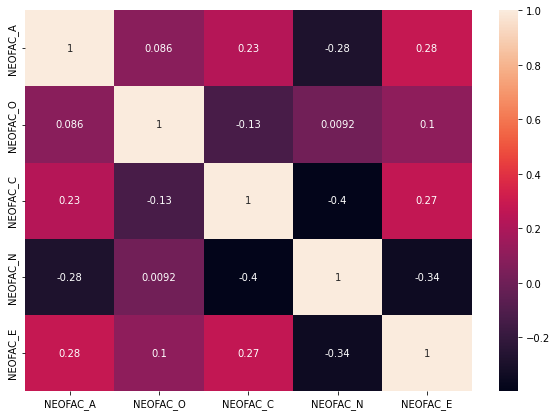

In [9]:
heat = response1.corr()

fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(heat, xticklabels=heat.columns, annot = True, )

array([[<AxesSubplot:title={'center':'FS_BrainSeg_Vol_No_Vent_Surf'}>,
        <AxesSubplot:title={'center':'FS_LCort_GM_Vol'}>],
       [<AxesSubplot:title={'center':'FS_RCort_GM_Vol'}>,
        <AxesSubplot:title={'center':'FS_TotCort_GM_Vol'}>],
       [<AxesSubplot:title={'center':'FS_R_Transversetemporal_Area'}>,
        <AxesSubplot:title={'center':'FS_L_Postcentral_Area'}>]],
      dtype=object)

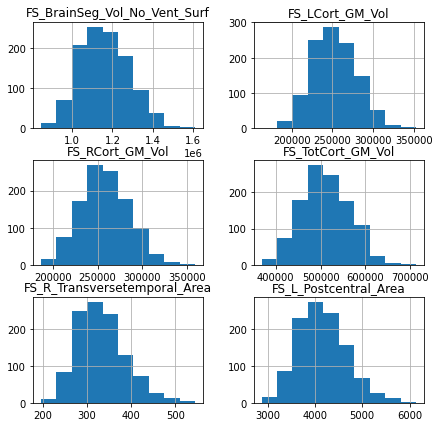

In [10]:
#spot check distribution, to check for normal distribution

df1[['FS_BrainSeg_Vol_No_Vent_Surf', 'FS_LCort_GM_Vol', 'FS_RCort_GM_Vol', 'FS_TotCort_GM_Vol', 'FS_R_Transversetemporal_Area', 'FS_L_Postcentral_Area']].hist(figsize = (7 , 7) )


array([[<AxesSubplot:title={'center':'NEOFAC_A'}>,
        <AxesSubplot:title={'center':'NEOFAC_O'}>],
       [<AxesSubplot:title={'center':'NEOFAC_C'}>,
        <AxesSubplot:title={'center':'NEOFAC_N'}>],
       [<AxesSubplot:title={'center':'NEOFAC_E'}>, <AxesSubplot:>]],
      dtype=object)

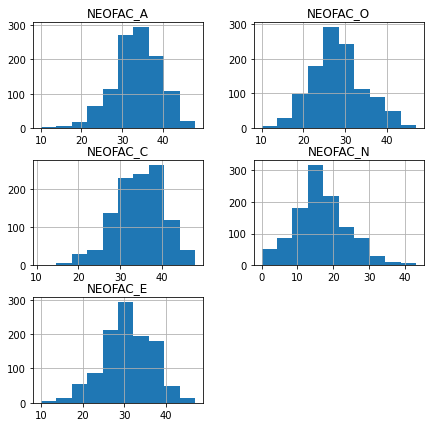

In [11]:
response1.hist(figsize = (7 , 7) )

<AxesSubplot:>

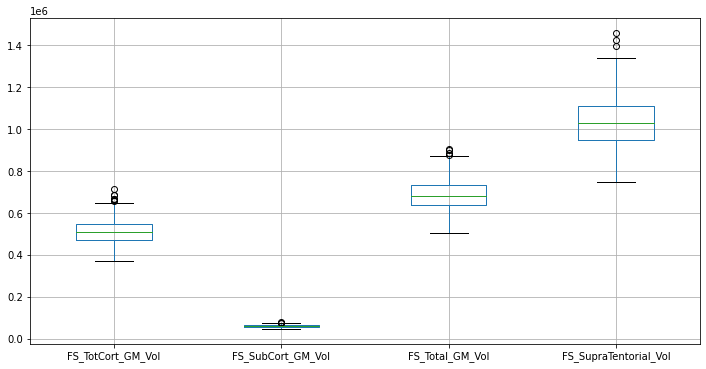

In [12]:
#spot check for outliers, nothing out of the ordinary
df1[['FS_TotCort_GM_Vol', 'FS_SubCort_GM_Vol', 'FS_Total_GM_Vol','FS_SupraTentorial_Vol',  ]].boxplot(figsize= (12,6))

<AxesSubplot:>

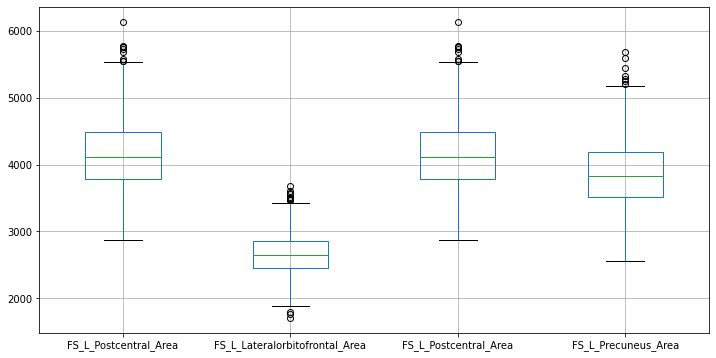

In [13]:
df1[['FS_L_Postcentral_Area', 'FS_L_Lateralorbitofrontal_Area','FS_L_Postcentral_Area', 'FS_L_Precuneus_Area']].boxplot(figsize= (12,6))

In [14]:
X = df1.drop(['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E'], axis = 1)
y = df1[['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']]

In [15]:
scaler  =  StandardScaler()
preprocessor = ColumnTransformer(transformers =[('scaler', scaler, list(X.columns))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

## <span style = 'color: DodgerBlue'> Machine Learning

In [16]:
linear = LinearRegression()

paramaters = {'linear_label__fit_intercept': [True, False]}

linear_model = Pipeline([
    ('preprocessor_label', preprocessor),
    ('linear_label', linear)
])


linear_gs = GridSearchCV(linear_model, param_grid = paramaters )
linear_score = linear_gs.fit(X_train, y_train).score(X_test, y_test)
linear_y_pred = linear_gs.predict(X_test)
linear_mae = mean_absolute_error(y_test, linear_y_pred ) 
linear_mse = mean_squared_error(y_test, linear_y_pred ) 
f'score: {linear_score},  mae: {linear_mae},  mse: {linear_mse} '


'score: -0.22749538503812677,  mae: 5.62000231034196,  mse: 49.28958794363371 '

In [17]:
knn = KNeighborsRegressor()
paramaters = {'knn_label__weights': ['distance', 'uniform'], 'knn_label__n_neighbors': [2,5,7 ]}

knn_model = Pipeline([
    ('preprocessor_label', preprocessor),
    ('knn_label', knn)
])


knn_gs = GridSearchCV(knn_model, param_grid = paramaters )
knn_score = knn_gs.fit(X_train, y_train).score(X_test, y_test)
knn_y_pred = knn_gs.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_y_pred ) 
knn_mse = mean_squared_error(y_test, linear_y_pred ) 
f'score: {knn_score}, mae: {knn_mae}, mse: {linear_mse} '

'score: -0.06227278755505723, mae: 5.215859708871593, mse: 49.28958794363371 '

## <span style = 'color: DodgerBlue'> Deep Learning

In [18]:
def tensor_flow_regression(X, y, outputlayer):
        tf.random.set_seed(0)
        
        neural_transformer = make_column_transformer(( MinMaxScaler(), list(X) ))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= 0 )

        neural_transformer.fit(X_train)
        X_train_normal = neural_transformer.transform(X_train)
        X_test_normal = neural_transformer.transform(X_test)

        neural = tf.keras.Sequential([
        tf.keras.layers.Dense(200),
        tf.keras.layers.Dense(200),
        tf.keras.layers.Dense(outputlayer)])

        neural.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics = [ tfa.metrics.r_square.RSquare(), 'mae', 'mse'] )

        earlystopping = callbacks.EarlyStopping(monitor ="r_square", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

        neural.fit(X_train_normal, y_train, epochs = 600, verbose = 0, callbacks = [earlystopping] )

        
        
        return neural.evaluate(X_test_normal, y_test)

In [19]:
regression_1 = tensor_flow_regression(X, y, 5)

7/7 [==============================] - 0s 834us/step - loss: 24.8078 - r_square: -17.6520 - mae: 24.8078 - mse: 698.0768


## <span style = 'color: DodgerBlue'> Dimensionality Reduction (features)

In [20]:
# variables for Surface_Area and Thickness are for the same structures, mulitply them to create a new size variable. The remaining 63 variable that are for other parts of the brain are not included

new_X = pd.np.multiply(X[['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingulate_Area', 'FS_L_Caudalmiddlefrontal_Area', 'FS_L_Cuneus_Area',  'FS_L_Entorhinal_Area', 'FS_L_Fusiform_Area', 'FS_L_Inferiorparietal_Area', 'FS_L_Inferiortemporal_Area', 'FS_L_Isthmuscingulate_Area',
'FS_L_Lateraloccipital_Area', 'FS_L_Lateralorbitofrontal_Area', 'FS_L_Lingual_Area', 'FS_L_Medialorbitofrontal_Area', 'FS_L_Middletemporal_Area', 'FS_L_Parahippocampal_Area', 'FS_L_Paracentral_Area', 'FS_L_Parsopercularis_Area', 'FS_L_Parsorbitalis_Area', 'FS_L_Parstriangularis_Area', 'FS_L_Pericalcarine_Area', 'FS_L_Postcentral_Area', 'FS_L_Posteriorcingulate_Area', 'FS_L_Precentral_Area', 'FS_L_Precuneus_Area', 
'FS_L_Rostralanteriorcingulate_Area', 'FS_L_Rostralmiddlefrontal_Area', 'FS_L_Superiorfrontal_Area', 'FS_L_Superiorparietal_Area', 'FS_L_Superiortemporal_Area', 'FS_L_Supramarginal_Area', 'FS_L_Frontalpole_Area', 'FS_L_Temporalpole_Area', 'FS_L_Transversetemporal_Area', 'FS_L_Insula_Area', 'FS_R_Bankssts_Area', 'FS_R_Caudalanteriorcingulate_Area', 'FS_R_Caudalmiddlefrontal_Area', 'FS_R_Cuneus_Area', 'FS_R_Entorhinal_Area', 'FS_R_Fusiform_Area', 'FS_R_Inferiorparietal_Area', 'FS_R_Inferiortemporal_Area', 'FS_R_Isthmuscingulate_Area', 
'FS_R_Lateraloccipital_Area', 'FS_R_Lateralorbitofrontal_Area', 'FS_R_Lingual_Area', 'FS_R_Medialorbitofrontal_Area', 'FS_R_Middletemporal_Area', 'FS_R_Parahippocampal_Area', 'FS_R_Paracentral_Area', 'FS_R_Parsopercularis_Area', 'FS_R_Parsorbitalis_Area', 'FS_R_Parstriangularis_Area', 'FS_R_Pericalcarine_Area', 'FS_R_Postcentral_Area', 'FS_R_Posteriorcingulate_Area', 'FS_R_Precentral_Area', 'FS_R_Precuneus_Area', 
'FS_R_Rostralanteriorcingulate_Area', 'FS_R_Rostralmiddlefrontal_Area', 'FS_R_Superiorfrontal_Area', 'FS_R_Superiorparietal_Area', 'FS_R_Superiortemporal_Area', 'FS_R_Supramarginal_Area', 'FS_R_Frontalpole_Area', 'FS_R_Temporalpole_Area', 'FS_R_Transversetemporal_Area', 'FS_R_Insula_Area']],
X[['FS_L_Bankssts_Thck', 'FS_L_Caudalanteriorcingulate_Thck', 'FS_L_Caudalmiddlefrontal_Thck', 'FS_L_Cuneus_Thck', 'FS_L_Entorhinal_Thck', 'FS_L_Fusiform_Thck', 'FS_L_Inferiorparietal_Thck', 'FS_L_Inferiortemporal_Thck', 'FS_L_Isthmuscingulate_Thck', 'FS_L_Lateraloccipital_Thck', 'FS_L_Lateralorbitofrontal_Thck', 'FS_L_Lingual_Thck', 'FS_L_Medialorbitofrontal_Thck', 'FS_L_Middletemporal_Thck', 'FS_L_Parahippocampal_Thck', 'FS_L_Paracentral_Thck', 'FS_L_Parsopercularis_Thck', 'FS_L_Parsorbitalis_Thck', 'FS_L_Parstriangularis_Thck', 'FS_L_Pericalcarine_Thck', 'FS_L_Postcentral_Thck', 'FS_L_Posteriorcingulate_Thck', 'FS_L_Precentral_Thck', 'FS_L_Precuneus_Thck', 'FS_L_Rostralanteriorcingulate_Thck', 'FS_L_Rostralmiddlefrontal_Thck', 'FS_L_Superiorfrontal_Thck', 'FS_L_Superiorparietal_Thck', 'FS_L_Superiortemporal_Thck', 'FS_L_Supramarginal_Thck', 'FS_L_Frontalpole_Thck', 'FS_L_Temporalpole_Thck', 'FS_L_Transversetemporal_Thck', 'FS_L_Insula_Thck', 'FS_R_Bankssts_Thck', 'FS_R_Caudalanteriorcingulate_Thck', 'FS_R_Caudalmiddlefrontal_Thck', 'FS_R_Cuneus_Thck', 'FS_R_Entorhinal_Thck', 'FS_R_Fusiform_Thck', 'FS_R_Inferiorparietal_Thck', 'FS_R_Inferiortemporal_Thck', 'FS_R_Isthmuscingulate_Thck', 'FS_R_Lateraloccipital_Thck', 'FS_R_Lateralorbitofrontal_Thck', 'FS_R_Lingual_Thck', 'FS_R_Medialorbitofrontal_Thck', 'FS_R_Middletemporal_Thck', 'FS_R_Parahippocampal_Thck', 'FS_R_Paracentral_Thck', 'FS_R_Parsopercularis_Thck', 'FS_R_Parsorbitalis_Thck', 'FS_R_Parstriangularis_Thck', 'FS_R_Pericalcarine_Thck', 'FS_R_Postcentral_Thck', 'FS_R_Posteriorcingulate_Thck', 'FS_R_Precentral_Thck', 'FS_R_Precuneus_Thck', 'FS_R_Rostralanteriorcingulate_Thck', 'FS_R_Rostralmiddlefrontal_Thck', 'FS_R_Superiorfrontal_Thck', 'FS_R_Superiorparietal_Thck', 'FS_R_Superiortemporal_Thck', 'FS_R_Supramarginal_Thck', 'FS_R_Frontalpole_Thck', 'FS_R_Temporalpole_Thck', 'FS_R_Transversetemporal_Thck', 'FS_R_Insula_Thck']])

C:\Users\jrick\AppData\Local\Temp\ipykernel_36100\2884656763.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  new_X = pd.np.multiply(X[['FS_L_Bankssts_Area', 'FS_L_Caudalanteriorcingulate_Area', 'FS_L_Caudalmiddlefrontal_Area', 'FS_L_Cuneus_Area',  'FS_L_Entorhinal_Area', 'FS_L_Fusiform_Area', 'FS_L_Inferiorparietal_Area', 'FS_L_Inferiortemporal_Area', 'FS_L_Isthmuscingulate_Area',
C:\Users\jrick\AppData\Local\Temp\ipykernel_36100\2884656763.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the u

In [21]:
new_X.shape

(1106, 68)

In [22]:
regression_2 = tensor_flow_regression(new_X, y, 5)

7/7 [==============================] - 0s 667us/step - loss: 26.9445 - r_square: -20.5379 - mae: 26.9445 - mse: 808.5659


In [23]:
linear_values = 'NaN', linear_score, linear_mae, linear_mse 
knn_values = 'NaN', knn_score, knn_mae, knn_mse


metrics_regression = pd.DataFrame({'Linear':  linear_values, 'Knn': knn_values, 'Regression_1': regression_1, 'Regression_2': regression_2   })
metrics_regression.insert(0, 'Metrics',  ['Loss', 'R_square', 'MAE', 'MSE'])
metrics_regression
#R_square values are negilible

,Metrics,Linear,Knn,Regression_1,Regression_2
0,Loss,NaN,NaN,24.807762,26.944452
1,R_square,-0.227495,-0.062273,-17.651997,-20.537931
2,MAE,5.620002,5.21586,24.807762,26.944452
3,MSE,49.289588,49.289588,698.076843,808.565857


Thus far all models tried have result in negative R_square indicating no pattern could be found. 

 ## <span style = 'color: DodgerBlue'> Dimensionality Reduction (responses)

In [24]:
#Rather than try to predict a continous variable, the response variables are turned into binary caterogiral variables. For example rather than trying to predict agreenableness between  0 and 48, then ensuing models will predict either 0 or 1 with 0 being low in agreeableness 1 being high.

y_new  = y.copy()

y_new['NEOFAC_A'] = np.where(y_new['NEOFAC_A'] > 29, 1, 0)   #29 is the mean of the means of the response variables
y_new['NEOFAC_O'] = np.where(y_new['NEOFAC_O'] > 29, 1, 0)
y_new['NEOFAC_C'] = np.where(y_new['NEOFAC_C'] > 29, 1, 0)
y_new['NEOFAC_N'] = np.where(y_new['NEOFAC_N'] > 29, 1, 0)
y_new['NEOFAC_E'] = np.where(y_new['NEOFAC_E'] > 29, 1, 0)

In [25]:
def tensor_flow_categorical(X, y, output_layer):
    tf.random.set_seed(0)
     

    neural_transformer = make_column_transformer(( MinMaxScaler(), list(X) ))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state= 0 )




    neural_transformer.fit(X_train)
    X_train_normal = neural_transformer.transform(X_train)
    X_test_normal = neural_transformer.transform(X_test)

    neural = tf.keras.Sequential([
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(100, activation= 'relu'),
            tf.keras.layers.Dense(output_layer, activation= 'sigmoid')])

    neural.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate= .01),
                    metrics = (['accuracy'], tf.keras.metrics.Precision(), tf.keras.metrics.Recall () ))

    earlystopping = callbacks.EarlyStopping(monitor ="accuracy", 
                                    mode ="min", patience = 5, 
                                    restore_best_weights = True)

 

    neural.fit(X_train_normal, y_train, epochs = 600, verbose = 0, callbacks = [earlystopping] )

    return neural.evaluate(X_test_normal, y_test)
        
       

In [26]:
categorical_1 = tensor_flow_categorical(X, y_new, 5 )
categorical_2 = tensor_flow_categorical(new_X, y_new, 5 )

7/7 [==============================] - 0s 833us/step - loss: 0.5236 - accuracy: 0.1171 - precision_1: 0.7327 - recall_1: 0.8370


In [27]:
cat_df = pd.DataFrame({'categorical_1': categorical_1, 'categorical_2' : categorical_2}) 
cat_df.insert(0, 'Metrics',  ['Loss', 'Accuracy', 'Precision', 'Recall'])
cat_df


#accuracy scores are identical and are only ~12%

,Metrics,categorical_1,categorical_2
0,Loss,0.520128,0.523607
1,Accuracy,0.117117,0.117117
2,Precision,0.732733,0.732733
3,Recall,0.837050,0.837050


 ## <span style = 'color: DodgerBlue'> Dimensionality Reduction (responses 2)

In [28]:
#Make the output easier to predict but dropping the number of responses from 5 to 4. This is done iteratively 

y_new_no_o = y_new.drop(['NEOFAC_O'], axis = 1, inplace = False)
y_new_no_c = y_new.drop(['NEOFAC_C'], axis = 1, inplace = False)
y_new_no_e = y_new.drop(['NEOFAC_E'], axis = 1, inplace = False)
y_new_no_a = y_new.drop(['NEOFAC_A'], axis = 1, inplace = False)
y_new_no_n = y_new.drop(['NEOFAC_N'], axis = 1, inplace = False)

In [29]:

CEAN_1 = tensor_flow_categorical(new_X, y_new_no_o, 4)
OEAN_2 = tensor_flow_categorical(new_X, y_new_no_c, 4)
OCAN_3 = tensor_flow_categorical(new_X, y_new_no_e, 4)
OCEN_4 = tensor_flow_categorical(new_X, y_new_no_a, 4)
OCEA_5 = tensor_flow_categorical(new_X, y_new_no_n, 4)

7/7 [==============================] - 0s 667us/step - loss: 0.5977 - accuracy: 0.1171 - precision_6: 0.7327 - recall_6: 0.8546


In [30]:
df_new = pd.DataFrame({ 'CEAN_1': CEAN_1, 'OEAN_2': OEAN_2,  'OCAN_3': OCAN_3, 'OCEN_4' : OCEN_4, 'OCEA_5': OCEA_5  })
df_new.insert(0, 'Metrics',  ['Loss', 'Accuracy', 'Precision', 'Recall'])
df_new


,Metrics,CEAN_1,OEAN_2,OCAN_3,OCEN_4,OCEA_5
0,Loss,0.487034,0.529224,0.503169,0.512985,0.597744
1,Accuracy,0.166667,0.819820,0.117117,0.518018,0.117117
2,Precision,0.732733,0.700450,0.772523,0.725225,0.732733
3,Recall,0.976000,0.766010,0.783105,0.772182,0.854641


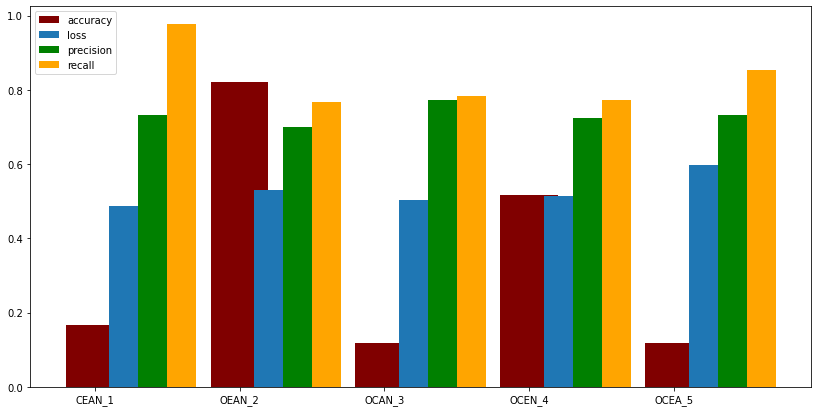

In [31]:
df_new = df_new.set_index('Metrics')
df1_new = df_new.T

plt.figure(figsize=(14, 7))
x_axis = np.arange(len(df1_new.index))
plt.bar(x_axis, df1_new["Accuracy"], color="maroon",label='accuracy',width=0.4) 
plt.bar(x_axis+0.2,df1_new["Loss"],label='loss',width=0.2 )
plt.bar(x_axis+0.4, df1_new["Precision"], color="green",label='precision',width=0.2)
plt.bar(x_axis+0.6, df1_new["Recall"], color="orange",label='recall',width=0.2)
plt.xticks(x_axis,df1_new.index)
plt.legend()


#relying primarly on the accuracy metric we can see that using OEAN_2 (droping conscientious) results in the best model

By dropping the response variable conscientiousness the accuracy of the model increases from 12% to 82%. It possible that conscientiousness is related to brain structures outside of dataset.

 ## <span style = 'color: DodgerBlue'> Retest Regression

In [32]:
#To elimnate the possibility that conscientiousness was responsible for the low R-Sqaures , conscientiousness was dropped from response variables and regression was used. However the r-square did not improve. 

y_new1 = y.drop('NEOFAC_C', axis = 1)
tensor_flow_regression(new_X,  y_new1, 4 )

7/7 [==============================] - 0s 833us/step - loss: 25.4823 - r_square: -18.8191 - mae: 25.4823 - mse: 737.7343


[25.482288360595703,
 -18.819103240966797,
 25.482288360595703,
 737.7343139648438]

 ## <span style = 'color: DodgerBlue'> Gender & Brain Structures 

Given that there are reliable differences between male and female brains I decided to see if gender would have an effect on the accuracy of the models.

In [33]:
#isolate Gender from oringal dataframe, rejoin with df and then drop null values

alpha = pd.merge(df, data[['Gender']], how = 'inner', left_index= True, right_index= True)
alpha1 = alpha.dropna()
gender = alpha1[['Gender']]
gender.shape

(1106, 1)

In [34]:
bravo = pd.merge(new_X, gender, how = 'inner', left_index= True, right_index= True)

In [35]:
male_feature = bravo.loc[bravo['Gender'] == 'M']
male_feature1 = male_feature.drop('Gender', axis= 1)
female_feature = bravo.loc[bravo['Gender'] == 'F']
female_feature1 = female_feature.drop('Gender' , axis =1 )
len(male_feature1), len(female_feature1)

(506, 600)

In [36]:
charlie= pd.merge(gender, y_new_no_c, how = 'inner', left_index= True, right_index= True)

male_response = charlie.loc[alpha['Gender'] == 'M']
male_response1 = male_response.drop('Gender', axis = 1)
female_response = charlie.loc[charlie['Gender'] == 'F']
female_response1 = female_response.drop('Gender', axis = 1)
len(male_response1), len(female_response1)

(506, 600)

In [37]:
male = tensor_flow_categorical(male_feature1, male_response1, 4)
female = tensor_flow_categorical(female_feature1, female_response1, 4)

4/4 [==============================] - 0s 1ms/step - loss: 0.4951 - accuracy: 0.9000 - precision_8: 0.7458 - recall_8: 0.7885


In [38]:
male_female = pd.DataFrame({'Male': male, 'Female': female }, index =  ['Loss', 'Accuracy', 'Precision', 'Recall'] )
male_female

,Male,Female
Loss,0.604861,0.495131
Accuracy,0.764706,0.900000
Precision,0.671569,0.745833
Recall,0.709845,0.788546


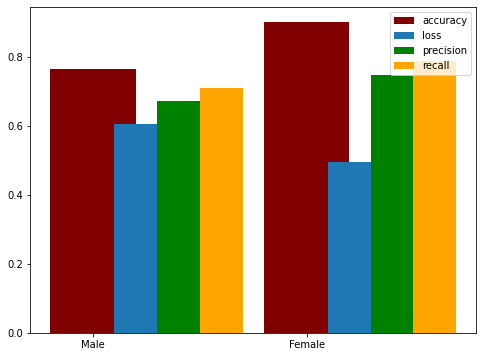

In [39]:
plt.figure(figsize=(8, 6))
x_axis = np.arange(len(male_female.T))
plt.bar(x_axis, male_female.T["Accuracy"], color="maroon",label='accuracy',width=0.4) 
plt.bar(x_axis+0.2,male_female.T["Loss"],label='loss',width=0.2 )
plt.bar(x_axis+0.4, male_female.T["Precision"], color="green",label='precision',width=0.2)
plt.bar(x_axis+0.6, male_female.T["Recall"], color="orange",label='recall',width=0.2)
plt.xticks(x_axis, male_female)
plt.legend()

The accuracy for females was 90% a higher score than males which was 76%. I hypothesized that this could be due to a  (contentious) theory known as the variablity hypothesis. Which states that in many instances of men comparisions between men and women, the variablity among men is greater than variablity of women. On example of this which was observed by Charles Darwin is the sizes of hands. There is greater variablity in the size of mens hands then there are in women. To check this hyposthesis I look at the standard deviation of men and women in the feature and response variables. 


In [40]:
male_std = np.round(np.mean(male_feature1.std()), 2)
female_std = np.round(np.mean(female_feature1.std()), 2)

In [41]:
delta = pd.merge(gender, y, how = 'inner', left_index= True, right_index= True)
delta.head()

,Gender,NEOFAC_A,NEOFAC_O,NEOFAC_C,NEOFAC_N,NEOFAC_E
1,M,29.0,23.0,26.0,21.0,32.0
2,F,37.0,24.0,35.0,15.0,37.0
3,M,33.0,29.0,34.0,15.0,33.0
4,M,31.0,33.0,36.0,7.0,15.0
5,F,30.0,23.0,39.0,13.0,29.0


In [42]:
male_delta = delta.loc[delta['Gender'] == 'M']
female_delta = delta.loc[delta['Gender'] == 'F']
male_delta1 = male_delta.drop('Gender', axis = 1)
female_delta1 = female_delta.drop('Gender', axis= 1) 

In [43]:
f_delta = np.round(np.mean(female_delta1.std()),2)
m_delta = np.round(np.mean(male_delta1.std()),2)

m_delta, f_delta

(6.36, 6.06)

In [44]:
gender_std = pd.DataFrame({'Male_Std': [male_std, m_delta], 'Female_Std': [female_std, f_delta]}, index = ['Brain Structure', 'Personality'])
gender_std

# accuracy of females is greater becasue of reduced variablity leading to a smaller standard deviation

,Male_Std,Female_Std
Brain Structure,796.38,919.87
Personality,6.36,6.06


My hypothesis proved correct, the standard deviation for women was smaller than that of men which is why the model had easier time predicting women

<u> Conclusion </u>:   I was able to succesfully use the size of brain structures to predict the personality of individual as determined by the Big Five taxomony. This was accomplished using Deep Learning  Sequential Model. The accuracy of the model was dependent on several dimensionality reduction techniques, primarely changing the response variables from  continious to categorical and droping the conscientiousness variable.

As a secondary findings it was discovered that the model was better able to predict female personality than male. It was demonstrated that this was due the reduced variabilty in female brain structure sizes and personality scores. This finding supports the variablity hypothesis of the sexes.